# News Articles Data Exploration

### Importing modules

In [56]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
plt.style.use('ggplot')

### Loading data

In [57]:
dataset = pd.read_csv("../data_processed/news_articles_joined.csv", index_col=0)

### Data Cleaning

Removing articles where the content is not string.

In [58]:
mask_string = dataset["content"].apply(lambda x: isinstance(x, str))
dataset = dataset[mask_string]

Selecting articles with more than 300 words

In [51]:
def word_count(text):
    return len(text.split())

In [61]:
dataset["word_count"] = dataset["content"].apply(word_count)

Setting a columns with the size of each article content.

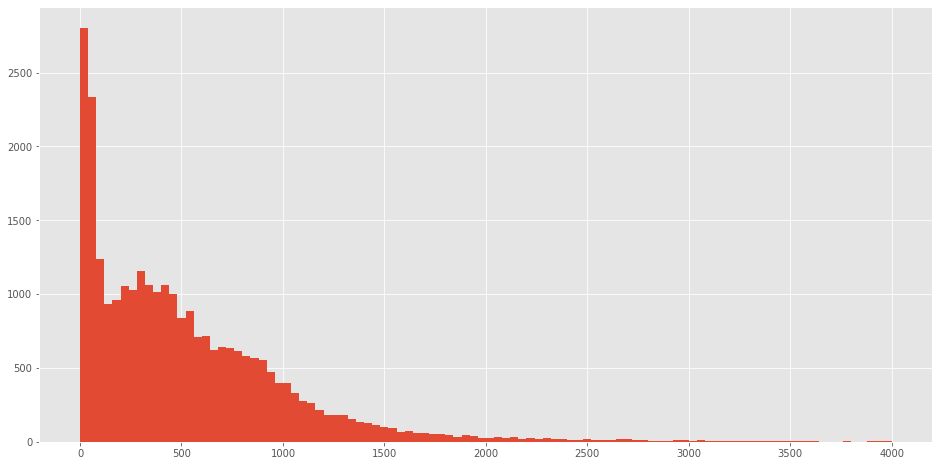

In [63]:
dataset["word_count"].hist(bins=100, range=(0, 4000), figsize=(16,8));

In [64]:
mask_size = dataset["word_count"] > 200
dataset = dataset[mask_size]

New histogram

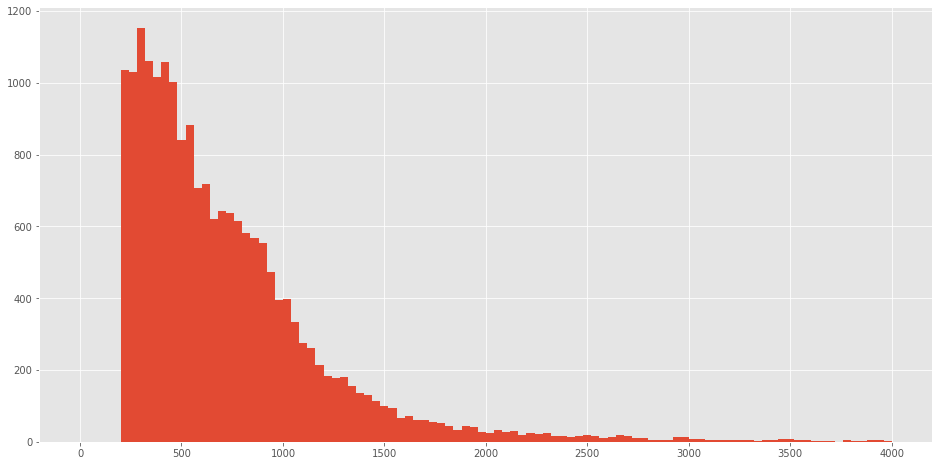

In [65]:
dataset["word_count"].hist(bins=100, range=(0, 4000), figsize=(16,8));

Cleaning publication names

In [12]:
def clean_publication(publication):
    # Leaving only the domain
    return re.sub(r"(https?://)?(www([0-9])?\.)?", "", publication)

In [13]:
cleaned_publication = dataset["publication"].apply(clean_publication)

In [14]:
dataset["domain"] = cleaned_publication

In [54]:
dataset.shape

(27827, 10)

### Pre selected news sources

Conservative news sorces and their bias level

In [16]:
conservative = {
    "reason.com": {
        "name": "Reason",
        "level": 1
    },
    "washingtontimes.com": {
        "name": "The Washington Times", 
        "level": 1
    },
    "nationareview.com": {
        "name": "National Review",
        "level": 2
    },
    "washingtonexaminer.com": {
        "name": "Washington Examiner",
        "level": 1
    },
    "thefederalist.com": {
        "name": "The Federalist",
        "level": 2
    },
    "foxnews.com": {
        "name": "Fox News",
        "level": 2
    },
    "nypost.com": {
        "name": "New York Post",
        "level": 2
    },
    "theblaze.com": {
        "name": "The Blaze",
        "level": 2
    },
    "dailycaller.com": {
        "name": "The Daily Caller",
        "level": 2
    },
    "dailywire.com": {
        "name": "The Daily Wire",
        "level": 2
    },
    "spectator.org": {
        "name": "Spectator",
        "level": 2
    }
}

Liberal news sources and their bias level

In [17]:
liberal = {
    "newyorker.com": {
        "name": "The New Yorker",
        "level": 2
    },
    "motherjones.com": {
        "name": "Mother Jones",
        "level": 2
    },
    "slate.com": {
        "name": "Slate",
        "level": 2
    },
    "msnbc.com": {
        "name": "MSNBC",
        "level": 2
    },
    "cnn.com": {
        "name": "CNN",
        "level": 2
    },
    "washingtonpost.com": {
        "name": "The Washington Post",
        "level": 1
    },
    "theguardian.com": {
        "name": "The Guardian",
        "level": 1
    },
    "nytimes.com": {
        "name": "The New York Times",
        "level": 1
    },
    "theatlantic.com": {
        "name": "The Atlantic",
        "level": 1
    },
    "nbcnews.com": {
        "name": "NBC News",
        "level": 1
    }
}

News sources considered "unbiased"

In [18]:
central = {
    "reuters.com": {
        "name": "Reuters",
        "level": 0
    },
    "csmonitor.com": {
        "name": "The Christian Science Monitor",
        "level": 0
    },
    "fivethirtyeight.com": {
        "name": "FiveThirtyEight",
        "level": 0
    },
    "bbc.com": {
        "name": "BBC News",
        "level": 0
    },
    "forbes.com": {
        "name": "Forbes",
        "level": 0
    }
}

In [19]:
all_sources = {**central, **liberal, **conservative}
selected_domains = all_sources.keys()

Some domains in the dataset doesn't contain content of they are not relevant.

In [20]:
domains_to_be_removed = [
    "radio.foxnews.com", 
    "video.foxnews.com", 
    "money.cnn.com",
    "s2.washingtonpost.com",
    "video.newyorker.com",
    "jobs.washingtonpost.com",
    "live.washingtonpost.com",
    "feeds.foxnews.com"
]

In [21]:
contains_text_to_be_removed = ["cnn sport", "cnn business"]
url_pattern_to_be_removed = ["theguardian.com/music/", "theguardian.com/technology/"]

In [22]:
# Filter to keep entries where the domain is valid
def keep_by_domain(domain):
    response = False
    for check in selected_domains:
        if (check in domain and domain not in domains_to_be_removed):
            response = True
    return response

In [23]:
# Filter to keep texts that doesn't contain texts that reference them as a non-relevant article
def keep_by_text(text):
    response = False
    for check in contains_text_to_be_removed:
        if check in text.lower():
            response = True
    
    return not response

In [24]:
# Filter to keep urls that doesn't contain pieces of strings that references them as a non-relevant article
def keep_by_url(url):
    response = False
    for check in url_pattern_to_be_removed:
        if check in url:
            response = True
    
    return not response    

In [25]:
mask_domain = dataset["domain"].apply(keep_by_domain)

In [26]:
mask_text = dataset["content"].apply(keep_by_text)

In [27]:
mask_url = dataset["url"].apply(keep_by_url)

In [28]:
selected_dataset = dataset[(mask_domain & mask_text & mask_url)].copy()

In [29]:
selected_dataset.shape

(8526, 11)

In [30]:
def normalize_domains(domain):
    response = domain
    for check in selected_domains:
        if check in domain:
            response = check
            
    return response

In [31]:
selected_dataset["domain"] = selected_dataset["domain"].apply(normalize_domains)

In [32]:
liberal_list = liberal.keys()
conservative_list = conservative.keys()

In [33]:
def bias_side(domain):
    if domain in liberal_list:
        response = 0
    elif domain in conservative_list:
        response = 1
    else:
        response = None
    
    return response

In [34]:
def bias_name(label):
    if label == 0:
        return "liberal"
    elif label == 1:
        return "conservative"
    else:
        return "central"

In [35]:
selected_dataset["label"] = selected_dataset["domain"].apply(bias_side)

In [36]:
selected_dataset["bias_name"] = selected_dataset["label"].apply(bias_name)

In [37]:
def bias_level(domain):
    domain_meta = all_sources.get(domain, {})
    return domain_meta.get("level")

In [38]:
selected_dataset["level"] = selected_dataset["domain"].apply(bias_level)

In [39]:
selected_dataset.head()

,title,publication,authors,date,year,month,url,content,content_size,word_count,domain,label,bias_name,level
0,Voicemail shows Trump lawyer asking Flynn's fo...,https://www.foxnews.com,['Greg Wilson'],NaN,NaN,NaN,https://www.foxnews.com/politics/voicemail-sho...,President Trump's one-time attorney asked Mich...,2904,459,foxnews.com,1.0,conservative,2
1,Trump defies close advisers in deciding to thr...,https://www.washingtonpost.com,"['Seung Min Kim', 'White House Reporter', 'Jos...",05-31-2019,2019.0,5.0,https://www.washingtonpost.com/politics/trump-...,President Trump speaks to reporters a the Whit...,9759,1530,washingtonpost.com,0.0,liberal,1
4,Trump to Kick Off His Re-election Campaign on ...,https://www.nytimes.com,"['Annie Karni', 'Maggie Haberman']",05-31-2019,2019.0,5.0,https://www.nytimes.com/2019/05/31/us/politics...,Mr. Trump has been staging “Make America Great...,1964,327,nytimes.com,0.0,liberal,1
5,"Trump administration to send DHS agents, inves...",https://www.washingtonpost.com,"['Nick Miroff', 'Reporter Covering Immigration...",05-31-2019,2019.0,5.0,https://www.washingtonpost.com/immigration/tru...,"\n\nHonduran migrants, part of a caravan tryin...",8661,1355,washingtonpost.com,0.0,liberal,1
9,"William Barr dishes on what Huber, Horowitz, a...",https://www.washingtonexaminer.com,[],05-31-2019,2019.0,5.0,https://www.washingtonexaminer.com/news/willia...,Attorney General William Barr gave his cleares...,5583,899,washingtonexaminer.com,1.0,conservative,1


### Classes balance

In [40]:
news_count = selected_dataset.groupby(["domain", "bias_name", "level"]).count()["publication"].reset_index()
news_count.columns = ["domain", "bias_name", "level", "count"]

In [41]:
news_count

,domain,bias_name,level,count
0,bbc.com,central,0,564
1,cnn.com,liberal,2,1685
2,dailycaller.com,conservative,2,8
3,dailywire.com,conservative,2,642
4,fivethirtyeight.com,central,0,92
5,forbes.com,central,0,719
6,foxnews.com,conservative,2,1018
7,motherjones.com,liberal,2,137
8,msnbc.com,liberal,2,102
9,nbcnews.com,liberal,1,593


**Number of articles by news sources**

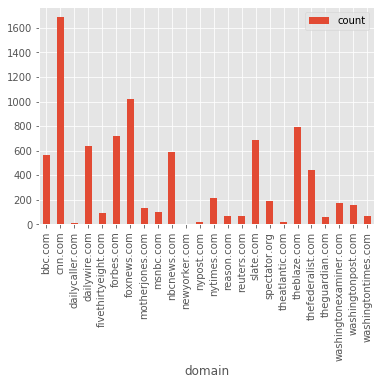

In [42]:
news_count.plot(kind="bar", x="domain", y="count");

**Number of articles by bias**

In [43]:
bias_count = news_count.groupby("bias_name").sum().reset_index()
bias_count["percentage"] = bias_count["count"] / bias_count["count"].sum() * 100
bias_count = bias_count[["bias_name", "percentage", "count"]]

In [44]:
bias_count

,bias_name,percentage,count
0,central,16.971616,1447
1,conservative,40.112597,3420
2,liberal,42.915787,3659


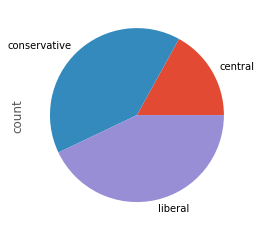

In [45]:
bias_count.set_index("bias_name").plot(kind="pie", y="count", legend=None);

**Number or articles by level**

In [ ]:
news_by_level = pd.pivot_table(news_count[news_count["level"] > 0], columns="bias_name", index="level", aggfunc=np.sum)
news_by_level.columns = news_by_level.columns.droplevel()

In [ ]:
news_by_level.plot.bar(stacked=True);

In [ ]:
news_by_level

### Exporting data

In [ ]:
# selected_dataset.to_csv("../data_processed/selected_articles_webhose_google_news.csv")